# Прогнозирование температуры звезды

`Задача` - придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд

## Описание данных

**Согласно документации к данным:**
* `Temperature (K)` — температура на поверхности звезды в Кельвинах
* `Luminosity(L/Lo)` —  относительная светимость L/Lo — светимость звезды относительно Солнца
* `Radius(R/Ro)` — относительный радиус R/Ro — радиус звезды относительно радиуса Солнца
* `Absolute magnitude(Mv)` — абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды
* `Star type` — тип звезды
* `Star color` — звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа

## Загрузка данных

In [1]:
# Подключение библиотек
import sys
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch import optim
from math import ceil
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

def seed_fn(seed, worker_id=0):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
seed_fn(67)

In [2]:
try:
    df = pd.read_csv('sun.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/6_class.csv', index_col=0)

## Предобработка и анализ данных

In [3]:
df.head()

,Unnamed: 0.1,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 7 columns):
Unnamed: 0.1              240 non-null int64
Temperature (K)           240 non-null int64
Luminosity(L/Lo)          240 non-null float64
Radius(R/Ro)              240 non-null float64
Absolute magnitude(Mv)    240 non-null float64
Star type                 240 non-null int64
Star color                240 non-null object
dtypes: float64(3), int64(3), object(1)
memory usage: 15.0+ KB


In [5]:
df.describe()

,Unnamed: 0.1,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Помимо 6 переменных, описанных в документации, появились 2 новых. **Unnamed: 0** и **Unnamed: 0.1**

Судя по всему в них хранятся индексы каждой строки, то есть бесполезная информация для любой модели машинного обучения. Проверим это

In [6]:
df.drop(['Unnamed: 0.1'],axis= 1, inplace=True)

### Количественные признаки

**Температура звезд в Кельвинах**

**Важно!!**

В ходе анализа и отброса выбросов была утеряна половинина типов звезд, следовательно то, что я выделил изначально было не выбросами 🧐🧐🧐. Снизу очистку закомментирую

In [7]:
df['Temperature (K)'].describe()

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64

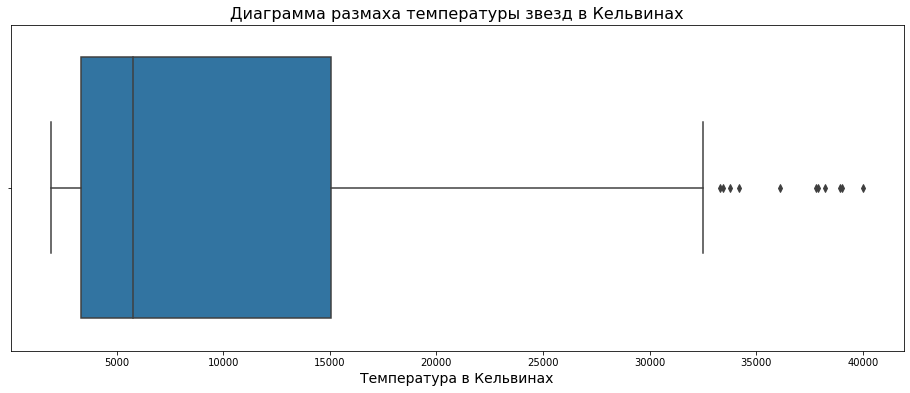

In [8]:
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(x = df["Temperature (K)"])
boxplot.axes.set_title("Диаграмма размаха температуры звезд в Кельвинах", fontsize=16)
boxplot.set_xlabel("Температура в Кельвинах", fontsize=14)
plt.show()

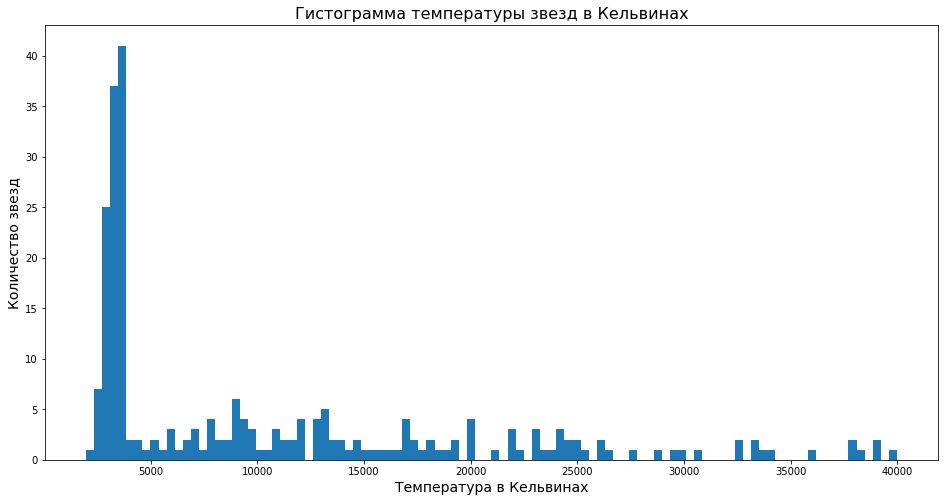

In [9]:
plt.figure(figsize=(16,8))
plt.hist(df['Temperature (K)'], bins = 100)
plt.ylabel('Количество звезд', fontsize = 14)
plt.xlabel('Температура в Кельвинах', fontsize = 14)
plt.title('Гистограмма температуры звезд в Кельвинах', fontsize = 16)
plt.show()

По данным графикам мы видим, что температура большинства звезд находится в пределах от 3500 до 15000 Кельвинов. У данного признака есть выбросы, согласно боксплоту они начинаются от 33000 Кельвинов и выше. Их можно удалить

In [10]:
# Удаление выбросов
df = df.rename(columns={"Temperature (K)": "Temperature"})
#ind_missing = df.query('Temperature > 33000').index
#df.drop(ind_missing, axis=0, inplace = True)

**Относительная светимость L/Lo**

In [11]:
df['Luminosity(L/Lo)'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64

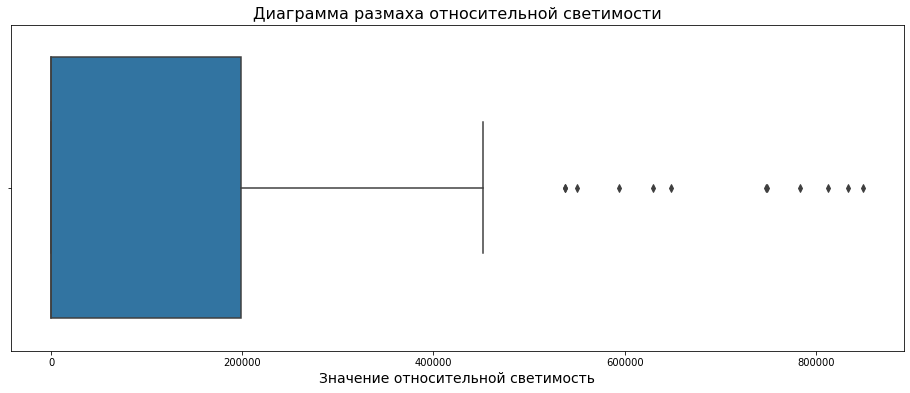

In [12]:
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(x = df["Luminosity(L/Lo)"])
boxplot.axes.set_title("Диаграмма размаха относительной светимости", fontsize=16)
boxplot.set_xlabel("Значение относительной светимость", fontsize=14)
plt.show()

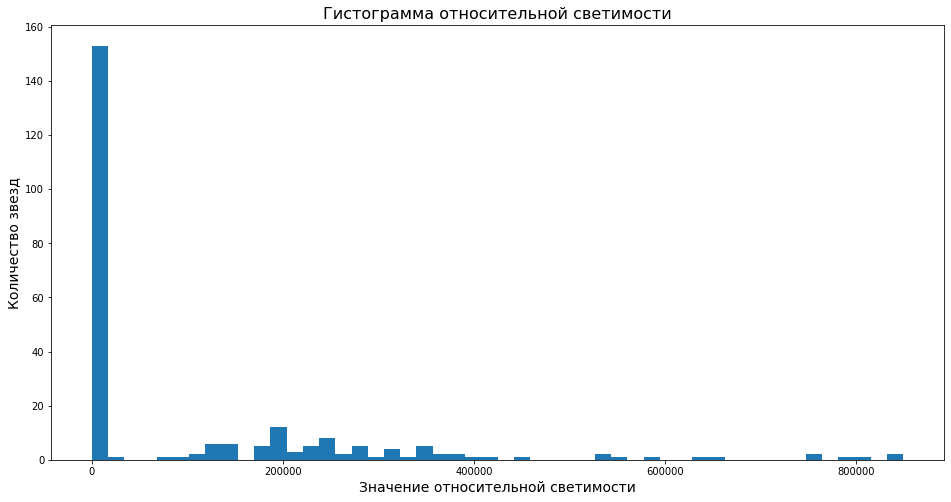

In [13]:
plt.figure(figsize=(16,8))
plt.hist(df['Luminosity(L/Lo)'], bins = 50)
plt.ylabel('Количество звезд', fontsize = 14)
plt.xlabel('Значение относительной светимости', fontsize = 14)
plt.title('Гистограмма относительной светимости', fontsize = 16)
plt.show()

In [14]:
df = df.rename(columns={"Luminosity(L/Lo)": "Luminosity"})

In [15]:
len(df.query('Luminosity < 0.1'))/df.shape[0] * 100

50.416666666666664

Больше половины наблюдений имеют значение относительной светимости около 0. В качестве правой границы примем значение в 40000

In [16]:
#ind_missing = df.query('Luminosity > 40000').index
#df.drop(ind_missing, axis=0, inplace = True)

**Относительный радиус**

In [17]:
df['Radius(R/Ro)'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64

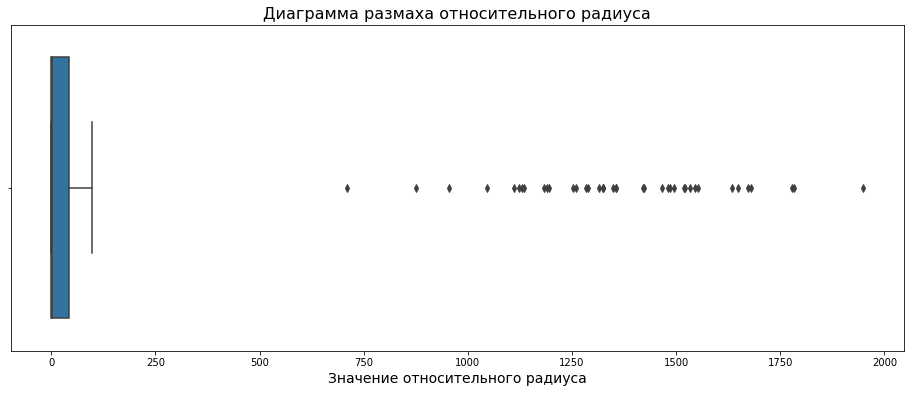

In [18]:
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(x = df["Radius(R/Ro)"])
boxplot.axes.set_title("Диаграмма размаха относительного радиуса", fontsize=16)
boxplot.set_xlabel("Значение относительного радиуса", fontsize=14)
plt.show()

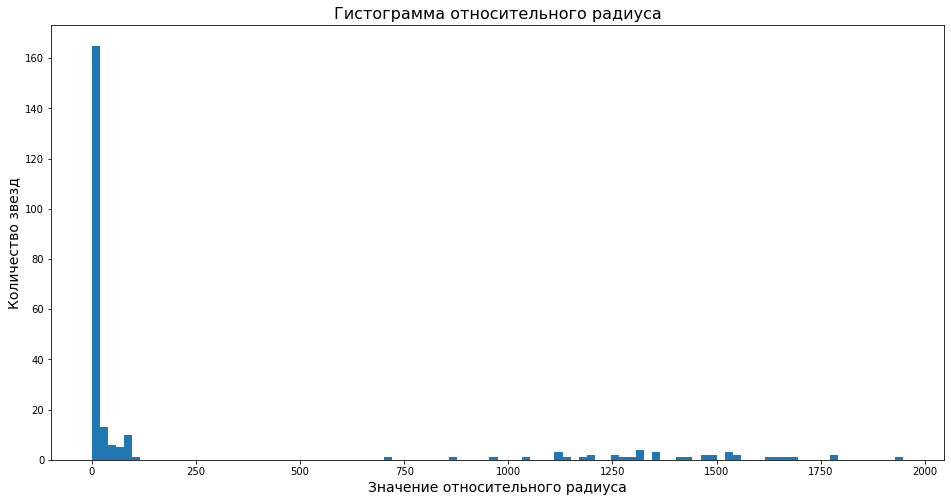

In [19]:
plt.figure(figsize=(16,8))
plt.hist(df['Radius(R/Ro)'], bins=100)
plt.ylabel('Количество звезд', fontsize = 14)
plt.xlabel('Значение относительного радиуса', fontsize = 14)
plt.title('Гистограмма относительного радиуса', fontsize = 16)
plt.show()

Опять же большинство значений относительного радиуса скопилось возле 0

In [20]:
df = df.rename(columns={"Radius(R/Ro)": "Radius"})
#ind_missing = df.query('Radius > 1.3').index
#df.drop(ind_missing, axis=0, inplace = True)

**Абсолютная звёздная величина**

In [21]:
df['Absolute magnitude(Mv)'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64

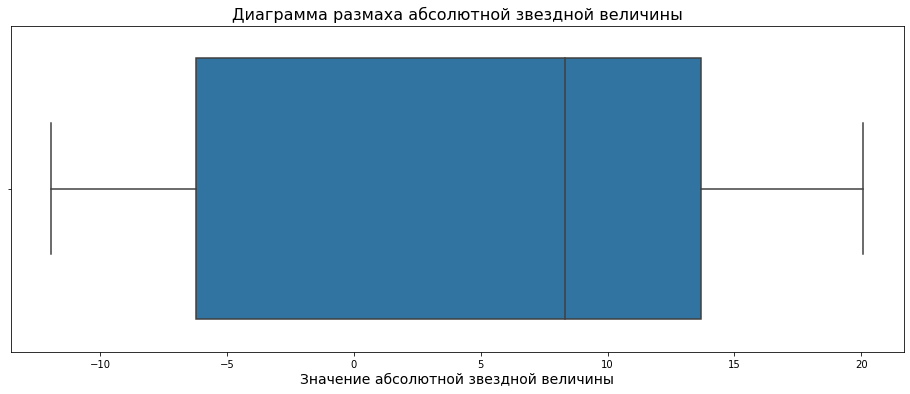

In [22]:
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(x = df["Absolute magnitude(Mv)"])
boxplot.axes.set_title("Диаграмма размаха абсолютной звездной величины", fontsize=16)
boxplot.set_xlabel("Значение абсолютной звездной величины", fontsize=14)
plt.show()

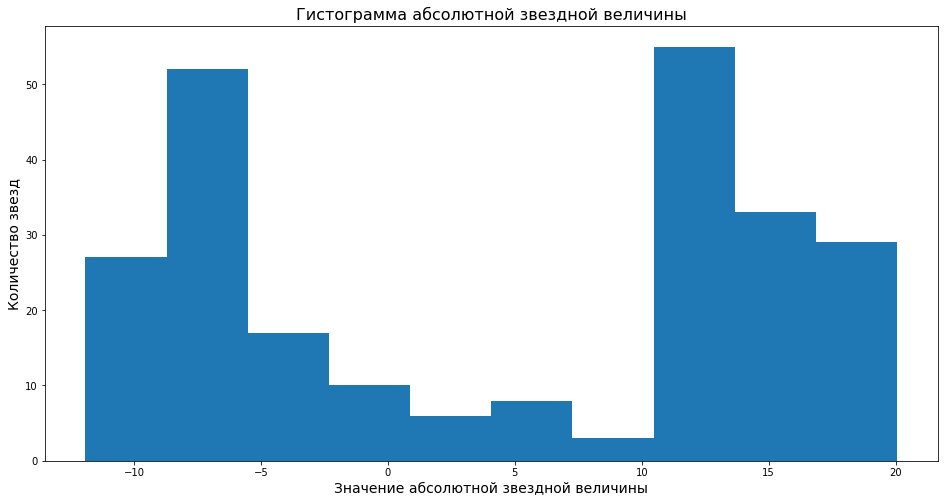

In [23]:
plt.figure(figsize=(16,8))
plt.hist(df['Absolute magnitude(Mv)'])
plt.ylabel('Количество звезд', fontsize = 14)
plt.xlabel('Значение абсолютной звездной величины', fontsize = 14)
plt.title('Гистограмма абсолютной звездной величины', fontsize = 16)
plt.show()

In [24]:
df = df.rename(columns={"Absolute magnitude(Mv)": "Absolute_magnitude"})
#ind_missing = df.query('Absolute_magnitude < 5').index
#df.drop(ind_missing, axis=0, inplace = True)

### Категориальные признаки

In [25]:
df['Star type'].value_counts()

5    40
4    40
3    40
2    40
1    40
0    40
Name: Star type, dtype: int64

In [26]:
df = df.rename(columns={"Star type": "Star_type"})

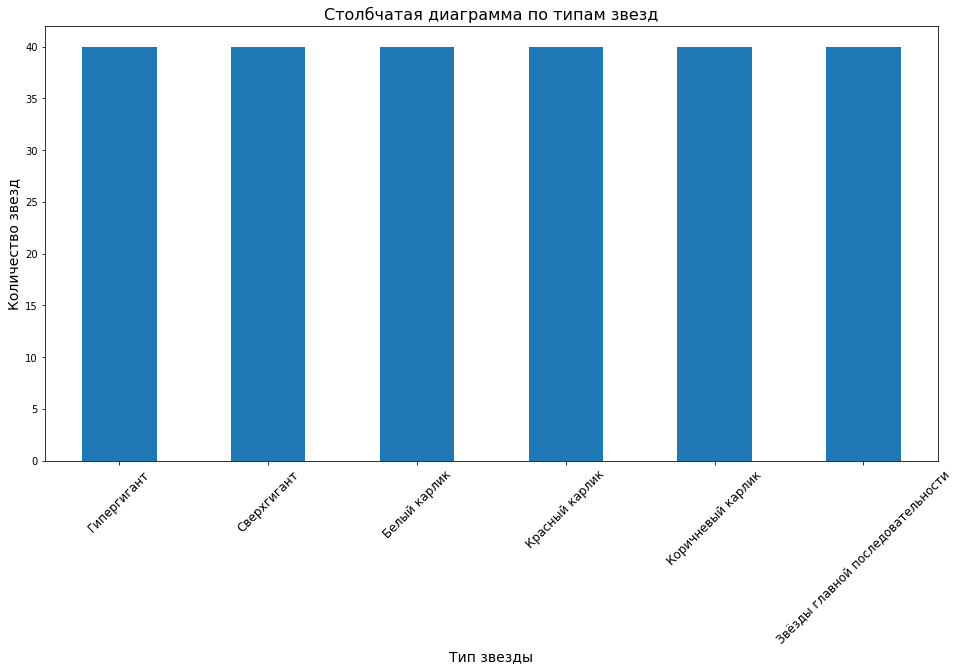

In [27]:
fig, ax = plt.subplots()
ax = df['Star_type'].value_counts().plot.bar()
ax.set_xticklabels(['Гипергигант', 'Сверхгигант', 'Белый карлик', 'Красный карлик', 'Коричневый карлик', 'Звёзды главной последовательности'],
                  rotation = 45,
                  fontsize = 12)


fig.set_figwidth(16)
fig.set_figheight(8)

plt.xlabel('Тип звезды', fontsize = 14)
plt.ylabel('Количество звезд', fontsize = 14)
plt.title('Столбчатая диаграмма по типам звезд', fontsize = 16)

plt.show()

У всех категорий одинаковая встречаемость.

**Star color**

In [28]:
df = df.rename(columns={"Star color": "Star_color"})

In [29]:
df['Star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Orange                  2
Whitish                 2
yellowish               2
Yellowish               1
Pale yellow orange      1
White-Yellow            1
Blue                    1
Orange-Red              1
Blue-White              1
Blue white              1
Name: Star_color, dtype: int64

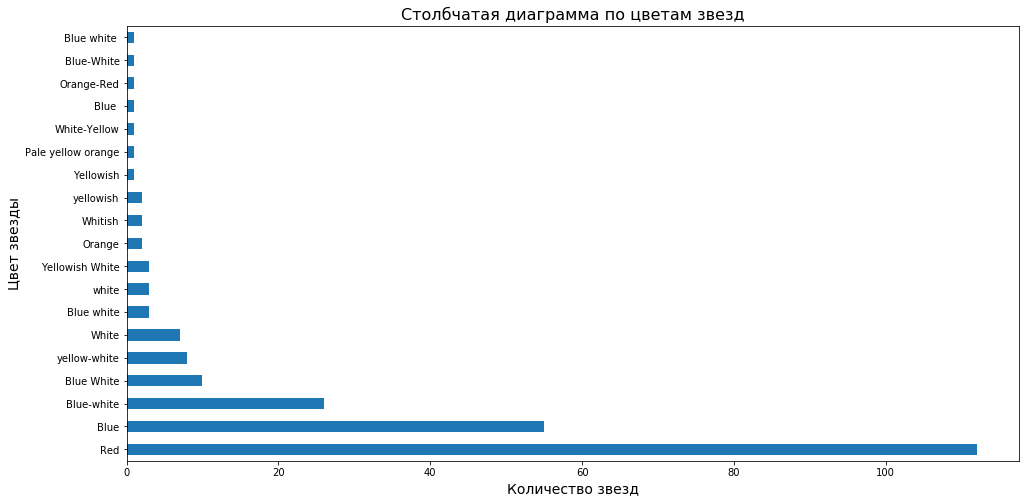

In [30]:
fig, ax = plt.subplots()
ax = df['Star_color'].value_counts().plot.barh()


fig.set_figwidth(16)
fig.set_figheight(8)

plt.xlabel('Количество звезд', fontsize = 14)
plt.ylabel('Цвет звезды', fontsize = 14)
plt.title('Столбчатая диаграмма по цветам звезд', fontsize = 16)

plt.show()

Тут есть неявные дубликаты. Для начала нужно привести все к нижнему регистру и удалить лишние пробелы

In [31]:
df['Star_color'] = df['Star_color'].str.lower()
df['Star_color'] = df['Star_color'].str.strip()

In [32]:
df['Star_color'].value_counts()

red                   112
blue                   56
blue-white             27
blue white             14
white                  10
yellow-white            8
yellowish white         3
yellowish               3
orange                  2
whitish                 2
white-yellow            1
orange-red              1
pale yellow orange      1
Name: Star_color, dtype: int64

In [33]:
def clean(col):
    if col == 'blue white':
        return 'blue-white'
    elif col == 'red' or col == 'blue-white' or col == 'blue': 
        return col
    else:
        return 'other'
    
df['Star_color'] = df['Star_color'].apply(clean)

In [34]:
df['Star_color'].value_counts()

red           112
blue           56
blue-white     41
other          31
Name: Star_color, dtype: int64

Далее проверим данные на наличие пропусков и дубликатов

### Пропуски и дубликаты

In [35]:
df.isnull().sum()

Temperature           0
Luminosity            0
Radius                0
Absolute_magnitude    0
Star_type             0
Star_color            0
dtype: int64

Пропуски отсутствуют

In [36]:
df.duplicated().sum()

0

Дубликаты так же отсутствуют

Теперь построим матрицу корреляции

### Матрица корреляции 

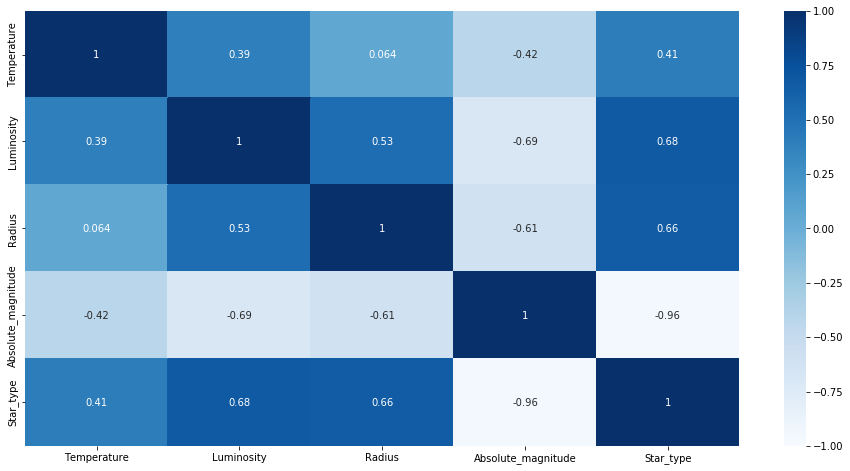

In [37]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap='Blues')
plt.show()

Заметна высокая отрицательная межфакторная корреляция между типом звезды и абсолютной звездной величиной (мультиколлинеарность). По идее стоило бы удалить одну из них, однако в ходе тестов удаление любого из этих признаков ухудшает модель


## Построение базовой нейронной сети

### OHE кодирование категориального признака

In [38]:
cat_cols = ["Star_color"]
cat_cols_encoded = []
for col in cat_cols:
    cat_cols_encoded += [f"{col[0:4]}_{cat}" for cat in list(df[col].unique())]

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cols = ohe.fit_transform(df[cat_cols])
df_enc = pd.DataFrame(encoded_cols, columns=cat_cols_encoded)
df = df.join(df_enc)


df.drop(['Star_color'], axis= 1, inplace=True)
df

,Temperature,Luminosity,Radius,Absolute_magnitude,Star_type,Star_red,Star_blue-white,Star_other,Star_blue
0,3068,0.002400,0.1700,16.12,0,0.0,0.0,0.0,1.0
1,3042,0.000500,0.1542,16.60,0,0.0,0.0,0.0,1.0
2,2600,0.000300,0.1020,18.70,0,0.0,0.0,0.0,1.0
3,2800,0.000200,0.1600,16.65,0,0.0,0.0,0.0,1.0
4,1939,0.000138,0.1030,20.06,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,1.0,0.0,0.0,0.0
236,30839,834042.000000,1194.0000,-10.63,5,1.0,0.0,0.0,0.0
237,8829,537493.000000,1423.0000,-10.73,5,0.0,0.0,1.0,0.0
238,9235,404940.000000,1112.0000,-11.23,5,0.0,0.0,1.0,0.0


### Масштабирование количественных признаков

In [48]:
# Разбиение данных на обучающую и тестовую выборки в соотношении 70 на 30

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Temperature']), 
    df['Temperature'], 
    test_size=0.3,
    random_state = 67)

scaler = StandardScaler()
numeric_col = ['Luminosity','Absolute_magnitude', 'Radius']
X_train[numeric_col] = scaler.fit_transform(X_train[numeric_col])
X_test[numeric_col] = scaler.transform(X_test[numeric_col])

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [49]:
X_train.shape

torch.Size([168, 8])

In [50]:
X_test.shape

torch.Size([72, 8])

### Параметры нейросети

In [51]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 1400
n_hidden_neurons_2 = int(n_hidden_neurons_1 * 0.8)
n_out_neurons = 1 

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x
               

### Функция обучения

In [52]:
def train(net, x_train, y_train, x_test, y_test, epoches=1100, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
    epoches = epoches 
    train_losses = [] 
    test_losses = []
    test_preds = []
    for i in range(epoches):
        optimizer.zero_grad()

        preds = net(x_train).flatten()
        
        loss_train = torch.sqrt(criterion(preds, y_train))

        loss_train.backward()
        
        optimizer.step()
        
        with torch.no_grad():
        
            preds_test = net(x_test).flatten()
            
            loss_test = torch.sqrt(criterion(preds_test, y_test))

            sys.stdout.write('\r Epoch: %d, loss_train: %.5f, loss_test: %.5f'
                                %(i, loss_train.item(), loss_test.item()))
            sys.stdout.flush()
            
            train_losses.append(loss_train.item())
            test_losses.append(loss_test.item())
            if i == epoches - 1:
                preds_t = net(x_test).flatten().detach().numpy()
                test_preds.append(preds_t)
            
    return train_losses, test_losses, test_preds

In [53]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses_final, test_losses_final, test_preds = train(net, X_train, y_train, X_test, y_test, 800)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 799, loss_train: 3891.17407, loss_test: 3403.761967

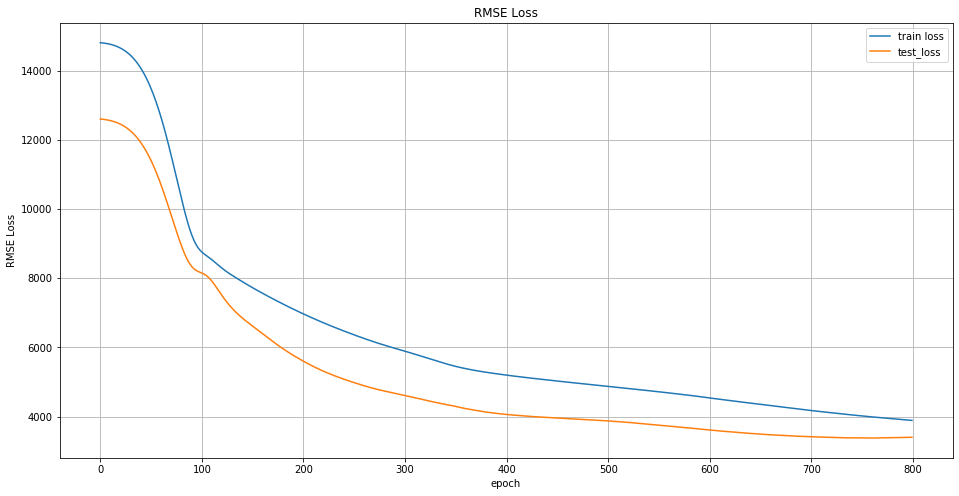

In [54]:
# Визуализация обучения нейросети

fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses_final[:])), train_losses_final[:])
ax = sns.lineplot(np.arange(len(test_losses_final[:])), test_losses_final[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

Составим список предсказаний и фактических значений на тестовой выборке

In [55]:
# Список предсказаний и фактических значений на тестовой выборке
preds = list(test_preds[0])
fact = list(y_test.numpy())

### График "Факт-прогноз"

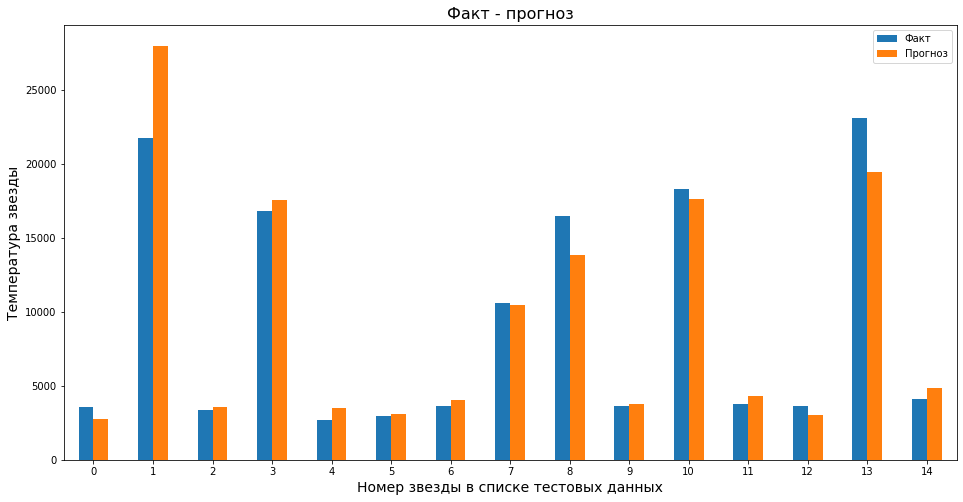

In [56]:
df_plot = pd.DataFrame({'Факт': fact[:15],
                    'Прогноз': preds[:15]})

ax = df_plot.plot.bar(rot=0, title='Сравнение предсказаний и реальных значений', figsize=(16,8))
plt.xlabel('Номер звезды в списке тестовых данных', fontsize = 14)
plt.ylabel('Температура звезды', fontsize = 14)
plt.title('Факт - прогноз', fontsize = 16)
plt.show()

Нейросеть обучена достаточно неплохо, попробуем улучшить ее 

## Эксперименты по улучшению нейронной сети

Попробуем добавить dropout и обучение с помощью разных батчей. 

Модернизируем функцию обучения и посчитаем RMSE с различными гиперпараметрами

### Dropout

In [57]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()
        self.dp1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.LeakyReLU()
        self.dp2 = nn.Dropout(p=0.8)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x

In [58]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses, test_losses, test_preds = train(net, X_train, y_train, X_test, y_test)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (dp1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (dp2): Dropout(p=0.8, inplace=False)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 1099, loss_train: 5222.78711, loss_test: 3870.99365

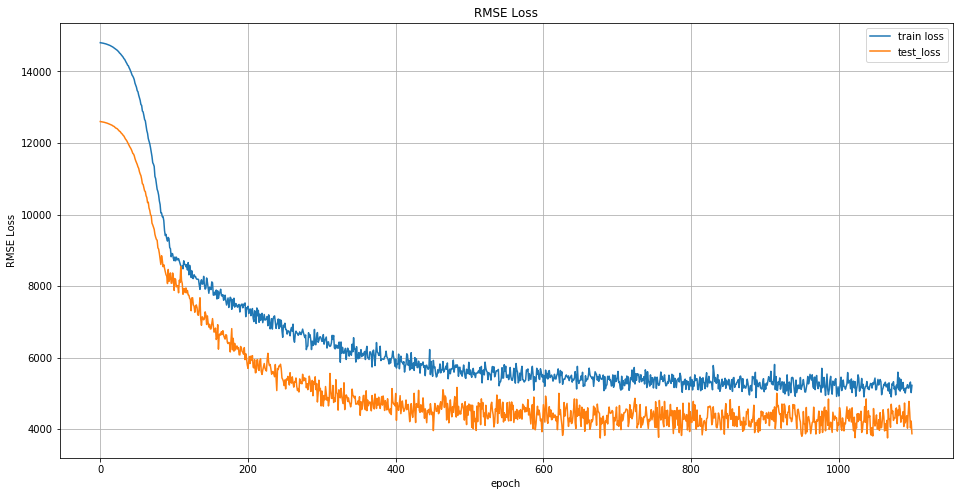

In [59]:
# Визуализация обучения нейросети

fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses[:])), train_losses[:])
ax = sns.lineplot(np.arange(len(test_losses[:])), test_losses[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

При добавлении дропаута обучение модели становится менее плавным и в данном случае вредит модели

Модифицируем функцию обучения, добавив батчи

### Батчи

In [60]:
# Сразу добавим нормализацию батчей
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)        

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x
    
def train_batch(net, x_train, y_train, x_test, y_test, batches, epoches, lr=1e-3):
    criterion = nn.MSELoss()
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
    
    epoches = epoches 
    
    batch_size = batches
    
    num_batches = ceil(len(x_train)/batch_size)
    
    train_losses = [] 
    test_losses = []
    test_preds = []
    tr_loss = []
    for i in range(epoches):
        
        order = np.random.permutation(len(x_train))
        
        for batch_idx in range(num_batches):
            
            start_index = batch_idx * batch_size
    
            optimizer.zero_grad()
            
            batch_indexes = order[start_index:start_index+batch_size]
            
            x_batch = x_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            preds = net(x_batch).flatten()

            loss_train = torch.sqrt(criterion(preds, y_batch))
            tr_loss.append(loss_train.item())
            loss_train.backward()

            optimizer.step()

        with torch.no_grad():

            preds_test = net(x_test).flatten()

            loss_test = torch.sqrt(criterion(preds_test, y_test))

            sys.stdout.write('\r Epoch: %d, loss_train_mean: %.5f, loss_test: %.5f'
                                %(i, sum(tr_loss)/len(tr_loss), loss_test.item()))
            sys.stdout.flush()

            train_losses.append(sum(tr_loss)/len(tr_loss))
            test_losses.append(loss_test.item())

            if i == epoches - 1:
                preds_t = net(x_test).flatten().detach().numpy()
                test_preds.append(preds_t)
            
    return train_losses, test_losses, test_preds

C помощью батчей по идее получится быстрее спуститься к минимуму функции потерь, поэтому уменьшим количество эпох

In [61]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses, test_losses, test_preds = train_batch(net, X_train, y_train, X_test, y_test, 20, 300)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (bn1): BatchNorm1d(1400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (bn2): BatchNorm1d(1120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 299, loss_train_mean: 8631.92181, loss_test: 4117.177738

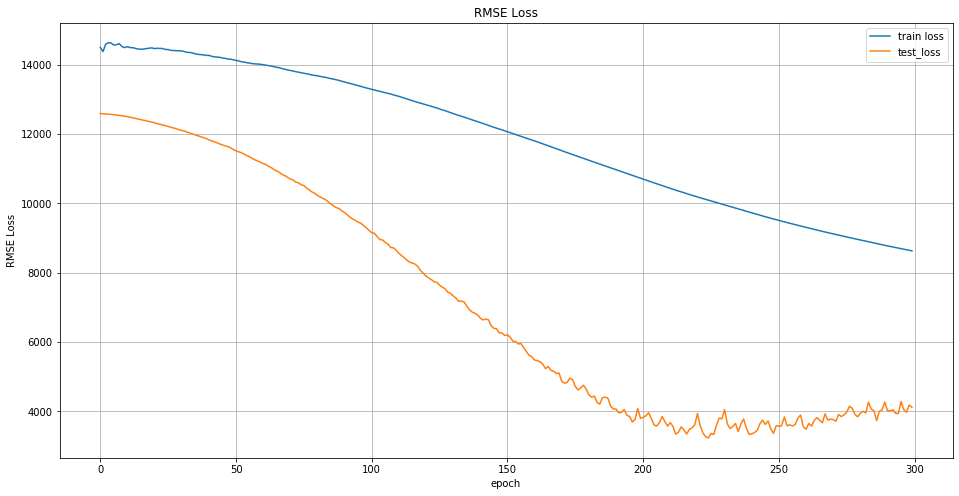

In [62]:
# Визуализация обучения нейросети

fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses[:])), train_losses[:])
ax = sns.lineplot(np.arange(len(test_losses[:])), test_losses[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

In [63]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses, test_losses, test_preds = train_batch(net, X_train, y_train, X_test, y_test, 40, 600)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (bn1): BatchNorm1d(1400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (bn2): BatchNorm1d(1120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 599, loss_train_mean: 8051.69829, loss_test: 4661.5493257

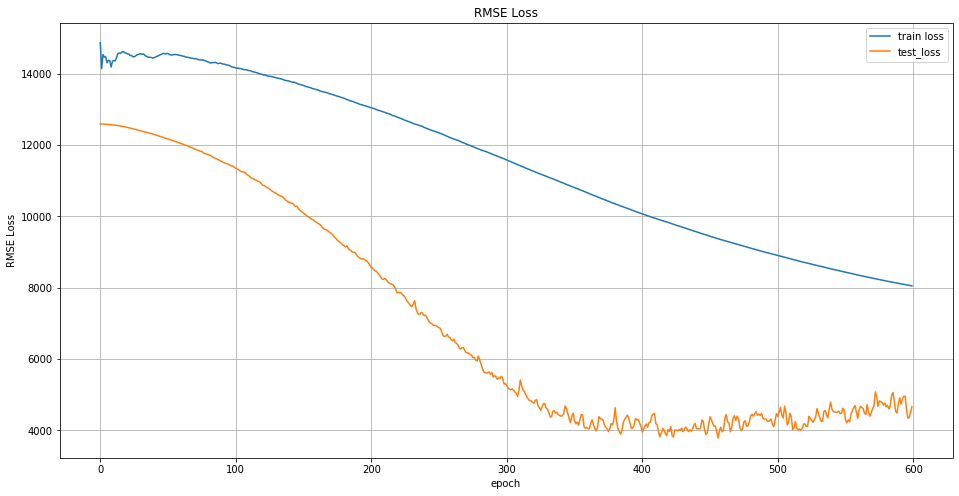

In [64]:
# Визуализация обучения нейросети

fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses[:])), train_losses[:])
ax = sns.lineplot(np.arange(len(test_losses[:])), test_losses[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

In [65]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses, test_losses, test_preds = train_batch(net, X_train, y_train, X_test, y_test, 80, 600)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (bn1): BatchNorm1d(1400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (bn2): BatchNorm1d(1120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 599, loss_train_mean: 10801.53340, loss_test: 4019.442145

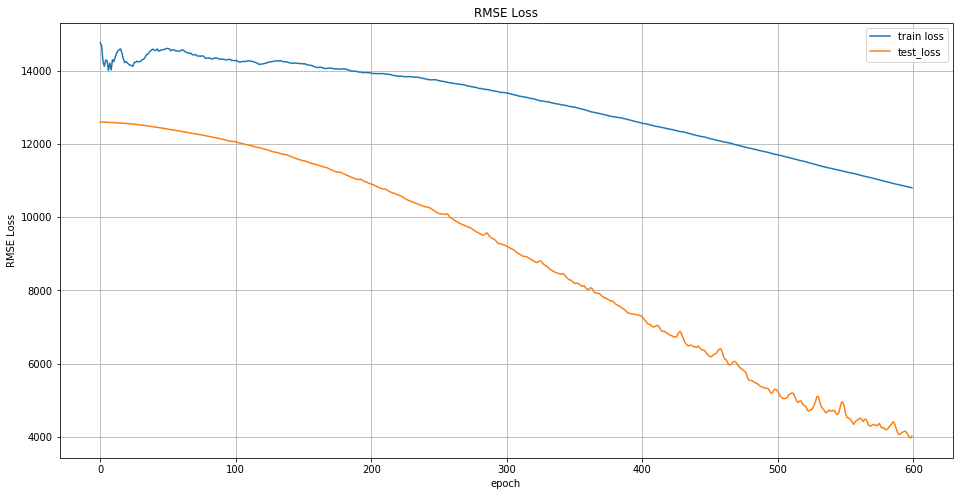

In [66]:
# Визуализация обучения нейросети

fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses[:])), train_losses[:])
ax = sns.lineplot(np.arange(len(test_losses[:])), test_losses[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

В общем и целом никакого улучшения добавления батчей нам не дало, поэтому лучшей моделью все еще считается первоначальная модель

Попробуем добавить в нее инициализацию весов и после попробуем изменить параметр learning_rate

### Инициализация весов

In [67]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x
    
def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 

In [68]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
net.apply(init_weights)
print(net)
train_losses, test_losses, test_preds = train(net, X_train, y_train, X_test, y_test, 800)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 799, loss_train: 3728.34692, loss_test: 3708.000731

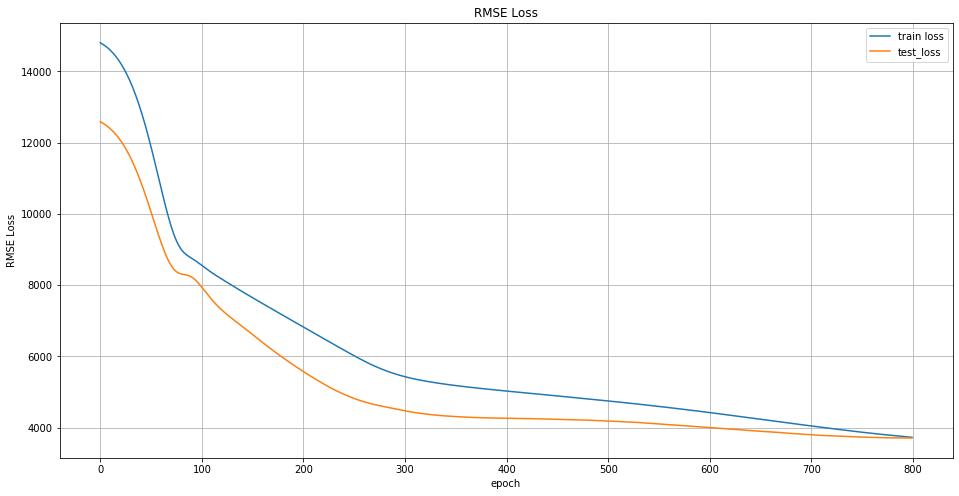

In [69]:
# Визуализация обучения нейросети

fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses[:])), train_losses[:])
ax = sns.lineplot(np.arange(len(test_losses[:])), test_losses[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

Со стандартной случайной инициализацией весов модель работала лучше на тесте

Теперь попробуем поменять параметр learning_rate

### Learning rate

In [70]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses, test_losses, test_preds = train(net, X_train, y_train, X_test, y_test, 1100, 1e-2)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 1099, loss_train: 2106.77612, loss_test: 4939.79883

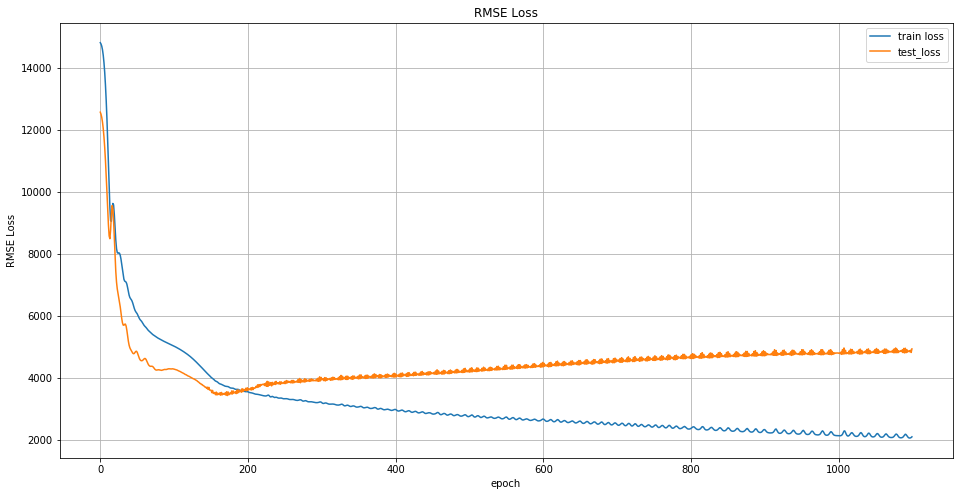

In [71]:
# Визуализация обучения нейросети

fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses[:])), train_losses[:])
ax = sns.lineplot(np.arange(len(test_losses[:])), test_losses[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

Увеличение скорости приводит к переобучению модели. Попробуем снизить скорость

In [72]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses, test_losses, test_preds = train(net, X_train, y_train, X_test, y_test, 1000, 0.001)

Net(
  (fc1): Linear(in_features=8, out_features=1400, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1400, out_features=1120, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1120, out_features=1, bias=True)
)
 Epoch: 999, loss_train: 3512.41748, loss_test: 3654.789555

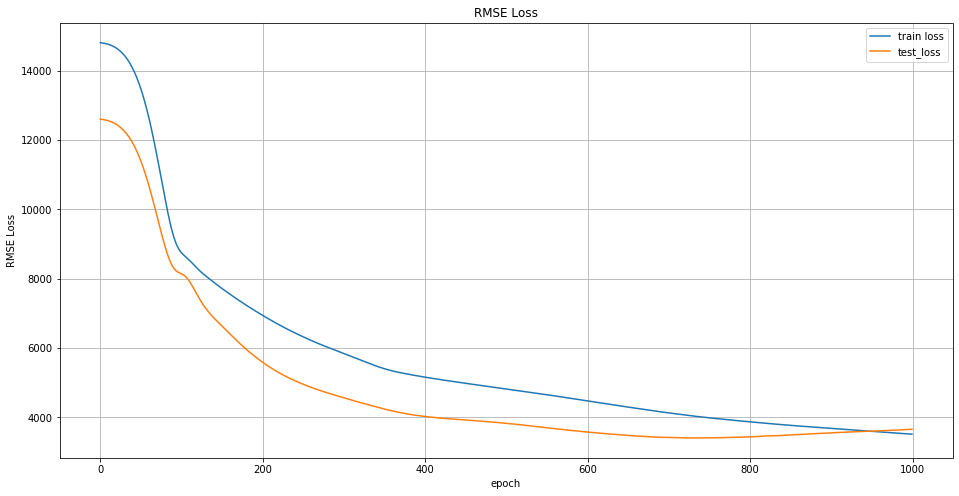

In [73]:
fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(np.arange(len(train_losses[:])), train_losses[:])
ax = sns.lineplot(np.arange(len(test_losses[:])), test_losses[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

Разницы практически никакой нет между первоначальной моделью и новой

In [74]:
# Список предсказаний и фактических значений на тестовой выборке
preds = list(test_preds[0])
fact = list(y_test.numpy())

### График "Факт-прогноз"

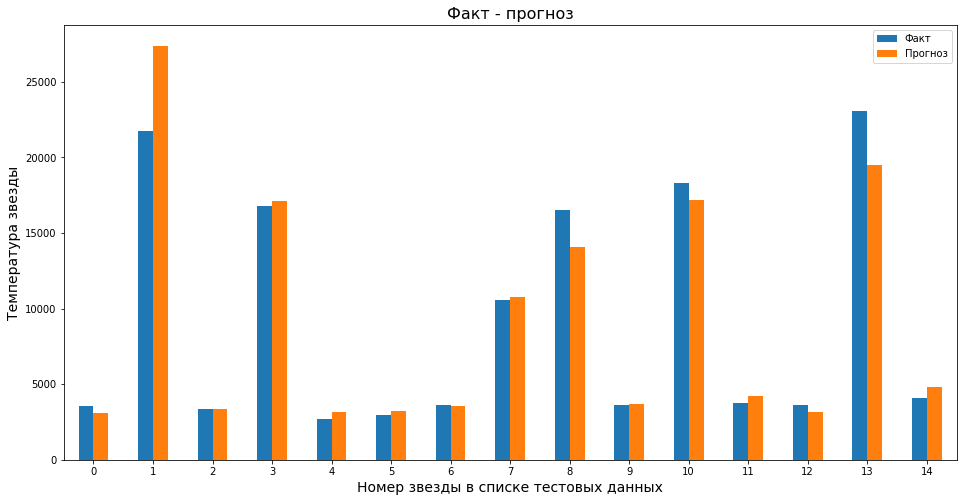

In [75]:
df_plot = pd.DataFrame({'Факт': fact[:15],
                    'Прогноз': preds[:15]})

ax = df_plot.plot.bar(rot=0, title='Сравнение предсказаний и реальных значений', figsize=(16,8))
plt.xlabel('Номер звезды в списке тестовых данных', fontsize = 14)
plt.ylabel('Температура звезды', fontsize = 14)
plt.title('Факт - прогноз', fontsize = 16)
plt.show()

In [76]:
# Табличка с результатами лучшей модели
total = pd.DataFrame({
                      'rmse_train':train_losses_final[-1],
                      'rmse_test':test_losses_final[-1]},index=[0])
total.index = ['Базовая модель']
total

,rmse_train,rmse_test
Базовая модель,3891.174072,3403.761963


К сожалению, улучшить первоначальную модель не получилось, но по условию задания метрика RMSE на тесте должна быть ниже 4500, с этим справились

## Выводы

В ходе проведенной работы была построена модель нейронной сети прямого распространения. Мне удалось снизить RMSE модели до 3300. Использование dropout, batchnorm, изменения инициализации весов и параметра скорости обучения модели не помогли добиться лучших результатов. Думаю, связано это с тем, что дропаут и нормализация батчей - это методы регуляризации, которые используются в случае переобучения модели, однако в нашем случае этого не было выявлено, соответственно и их примение в данной задаче не было необходимостью